In [3]:
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm

class StockData_target_asset():
    """
        훈련용 데이터세트와 평가용 데이터세트를 만들기 위한 과정.
        특정 에셋만 타겟으로 함.
        [T-window:T-1] => [T+h] 예측

        파라미터:
            folderPath : 종목시장의 주가 csv가 저장되어있는 디렉토리 경로.
            targetAsset : 타겟이 되는 에셋
            indexdata : 종목시장의 인덱스데이터 모음(INDEX_DATA)
            timewindowsize : LSTM의 입력으로 들어가는 타임의 사이즈.
                             10일 경우 미래주가를 예측하기 위해 이전 10일 주가를 사용.
            windowsizeForPCC : PCC를 계산하기 위해 사용되는 타임의 사이즈. 
                               10일 경우 관계주를 구하기 위해 이전 10일 주가를 사용.
            PositiveStockNumber : 긍정관계주 개수.
            NegativeStockNumber : 부정관계주 개수.
            train_test_rate : 훈련:평가 세트 비율. 0.7일 경우 생성된 데이터 세트중 70%는 훈련용, 30%는 평가용으로 사용.
            batchSize : 세트를 나누는 배치 사이즈.
            date_duration : 에셋별 데이터 길이 조정(default=250)
            h : 예측하는 미래 시점(defalt=1)

        과정:
            종목시장의 모든 종목의 시가와 인덱스 시가를 읽어옴.
            minmax스케일러를 각 종목과 인덱스에 적용하고 저장.
            PCC계산, 관계주 계산.
            데이터세트 저장.
               
    """
    def __init__(self,folderPath,targetAsset,indexdata,timewindowsize,windowsizeForPCC,PostiveStockNumber,NegativeStockNumber,train_test_rate,batchSize,date_duration=250,h=1):        
               
        if(train_test_rate<=0 or train_test_rate>1):
            raise ValueError('train_test_rate should be between 0 and 1')
        self.H=h-1
        self.P=PostiveStockNumber
        self.N=NegativeStockNumber        
        self.T=timewindowsize
        self.Tr=windowsizeForPCC
        self.folderPath = folderPath     
        self.target_asset = targetAsset
        self.batchSize=batchSize
        self.date_duration=date_duration
        
        self.train_test_rate=train_test_rate
        self.scaler=MinMaxScaler(feature_range=(-1,1))  
        self.indexScaler = MinMaxScaler(feature_range=(-1,1))
        
        self.include_asset = []
        self.not_include = pd.DataFrame([],dtype=object)
        self.include_index = []

        #self.indexPrice = self.loadIndex()
        self.stockPrice = self.loadCSV()
        self.indexData = self.scale_index(indexdata)

        self.trainSet,self.testSet=self.make_dataset()

        self.batchNum={}

    
    def getBatch(self,option):
        """
        클래스에 저장된 세트를 y,xp,xn,xi,target으로 나누고 batch생성.

        args:
            option='training' or 'evaluation'

        returns:
            batch 제너레이터
            batch={'y','xp','xn','xi','target'}
        """
        if(option != 'training' and option != 'evaluation'):
            raise ValueError('option should be "training" or "evaluation".')
        
        if(option == 'training'):
            returnSet = self.trainSet
        else:
            returnSet = self.testSet
        
        if returnSet is None:
            raise ValueError("train_test_rate is 1, so that it doesn't have test set.")
        
        y=[]
        xp=[]
        xn=[]
        xi=[]
        target=[]

        for d in returnSet:
            y.append(d['target_history'])  
            xp.append(d['pos_history'])       
            xn.append(d['neg_history'])       
            xi.append(d['index_history'])       
            target.append(d['target_price'])

        y=np.reshape(y,(-1,self.T,1))
        xp=np.reshape(xp,(-1,self.P,self.T,1))
        xn=np.reshape(xn,(-1,self.N,self.T,1))
        xi=np.reshape(xi,(-1,9,self.T,1))
        target=np.reshape(target,(-1,1))

        #print(f"{option:>14} data : " , y.shape,xp.shape,xn.shape,xi.shape,target.shape)     

        batchNum=int(len(y)/self.batchSize)
        self.batchNum[option]=batchNum

        for i in range(batchNum):
            yield {'y':y[i*self.batchSize:(i+1)*self.batchSize],
                   'xp':xp[i*self.batchSize:(i+1)*self.batchSize],
                   'xn':xn[i*self.batchSize:(i+1)*self.batchSize],
                   'xi':xi[i*self.batchSize:(i+1)*self.batchSize],
                   'target':target[i*self.batchSize:(i+1)*self.batchSize]}

    def loadCSV(self):
        """
        csv파일이 있는 폴더를 입력으로 받아 데이터를 읽어옴.
        """
        csvList=os.listdir(self.folderPath)

        for csv in csvList:
            data=pd.read_csv(self.folderPath+'/'+csv,engine='python',encoding = "cp949")
            if(len(data)>self.date_duration):
                data=data[-self.date_duration-1:-1]
                data=data.reset_index()
                data=data[['Date','Adj Close']]
                
                self.include_asset.append(csv[:-4])
                if csv == csvList[0]:
                    dataframe = data
                else:
                    dataframe = pd.merge(dataframe,data,how="outer",on="Date")
            else:
                self.not_include = self.not_include.append({"CSV":csv,"Length":len(data)}, ignore_index=True)
        dataframe["Date"] = pd.to_datetime(dataframe["Date"])
        dataframe.sort_values(by=['Date'],inplace=True)
        dataframe.fillna(method='ffill',inplace=True)
        dataframe.fillna(method='bfill',inplace=True)
        print(f'period : {dataframe["Date"].iloc[0]} ~ {dataframe["Date"].iloc[-1]}')
        
        dataT=dataframe.drop(columns = "Date").copy()
        cols = dataT.columns.copy()
        dataT=np.array(dataT)
        
        self.scaler.fit(dataT)
        dataT=self.scaler.transform(dataT)
        dataframe=pd.DataFrame(dataT)
        
        dataframe.columns = cols
        print('StockPrice shape: ',dataframe.shape)
        return dataframe


    def make_dataset(self):
        """
        예측모델에 사용되는 입력,타겟 데이터세트.
        입력데이터의 shape는 (목표주식+관계주식+인덱스, 타임윈도우사이즈)
        타겟데이터의 shape는 (1,1)
        """
        maxday=max([self.T,self.Tr])
        dataset=[]

        for i in tqdm(range(maxday,len(self.stockPrice)-self.H),desc = "making dataset progress",ncols=50):
            
            priceSet=self.stockPrice.loc[i-self.T:i-1]
            targetSet=self.stockPrice.loc[i+self.H]
            positiveSet,negativeSet=self.calculate_correlation(self.stockPrice.loc[i-maxday:i-1])
            indexSet = self.indexData.loc[i-self.T:i-1]
            
            
            if type(self.target_asset) is list:
                for targetNum in self.target_asset:
                    target_history=np.reshape(np.array(priceSet[targetNum]),(self.T,1))
                    pos_history=np.reshape(np.array(positiveSet[targetNum].T),(self.P,self.T,1))
                    neg_history=np.reshape(np.array(negativeSet[targetNum].T),(self.N,self.T,1))
                    index_history=np.reshape(np.array(indexSet),(9,self.T,1))#???요거 맞나...?아마 9열 맞을껄....?
                    target_price=np.reshape(np.array(targetSet[targetNum]),(1,1))

                    dataset.append({'target_history':target_history,
                                    'pos_history':pos_history,
                                    'neg_history':neg_history,
                                    'index_history':index_history,
                                    'target_price':target_price
                                   })
            elif type(self.target_asset) is str:
                target_history=np.reshape(np.array(priceSet[self.target_asset]),(self.T,1))
                pos_history=np.reshape(np.array(positiveSet[self.target_asset].T),(self.P,self.T,1))
                neg_history=np.reshape(np.array(negativeSet[self.target_asset].T),(self.N,self.T,1))
                index_history=np.reshape(np.array(indexSet),(9,self.T,1))#???요거 맞나...?아마 9열 맞을껄....?
                target_price=np.reshape(np.array(targetSet[self.target_asset]),(1,1))

                dataset.append({'target_history':target_history,
                                'pos_history':pos_history,
                                'neg_history':neg_history,
                                'index_history':index_history,
                                'target_price':target_price
                                })
            else:
                print(f'{self.target_asset}`s type : {type(self.target_asset)}')
                raise TypeError
        if self.train_test_rate == 1:
            return dataset,None
        else:
            return dataset[:int(len(dataset)*self.train_test_rate)],dataset[int(len(dataset)*self.train_test_rate):]

    def calculate_correlation(self,priceSet):
        """
        Pearson Correlation Coefficient(PCC)를 계산하고,
        높은순으로 긍정관계주, 낮은순으로 부정관계주를 설정한 개수만큼 생성하여 리스트에 저장한후, 리턴.
        입력은 전체 종목의 타임윈도우간의 주가.

        Returns:
            #모든종목의 관계주. 
            긍정관계주 shape = (종목 수, dataframe(T*P))
            부정관계주 shape = (종목 수, dataframe(T*N))
        """    
        positive=[]
        negative=[] 
        corr=priceSet[-self.Tr:].corr(method='pearson')

        for i in corr.columns:
            tempCorr=corr[i].sort_values(ascending=False)
            index_P=tempCorr[1:self.P+1].index
            index_N=tempCorr[-self.N:].index
            
            priceSet=priceSet[-self.T:]
            posSet=priceSet[index_P]
            negSet=priceSet[index_N]
            #posSet.columns=range(self.P)
            #negSet.columns=range(self.N)
            
            positive.append(posSet)
            negative.append(negSet)
        return positive,negative

    def scale_index(self, index_data):
        I = index_data.drop(columns = "Date").copy()
        self.indexScaler.fit(I)
        self.include_index = I.columns.to_list()
        return pd.DataFrame(self.indexScaler.transform(I))

In [23]:
set_1 = pd.DataFrame({"AA":[1,2,3,4],"BB":[2,3,-1,16],"CC":[-1,-2,-3,-4]})
corr = set_1[-4:].corr(method="pearson")
print(corr)
for i in corr.columns:
    print(corr[i].shape)
    tempcorr = corr[i].sort_values(ascending=False)
    p = tempcorr[1:2].index

          AA        BB        CC
AA  1.000000  0.651695 -1.000000
BB  0.651695  1.000000 -0.651695
CC -1.000000 -0.651695  1.000000
(3,)
(3,)
(3,)


In [10]:
ra = np.arange(164)
np.random.shuffle(ra)

c = 0
for i in ra:
    print(i)
    c+=1
    if c > 10:
        break

81
107
110
125
82
98
157
27
119
159
138


Text(0.5, 1.0, 'AA\nBB')

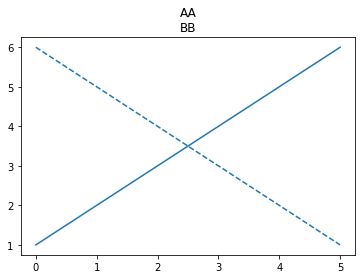

In [18]:
import matplotlib.pyplot as plt

l = [1,2,3,4,5,6]
l2 = [6,5,4,3,2,1]
plt.plot(l,"C0-")
plt.plot(l2,"C0--")
plt.title("AA\nBB")